1. На основе учебного ноутбука проведите финальную подготовку данных. Иизмените количество сегментирующих классов с `16` на `5`.

2. Проведите суммарно не менее `10` экспериментов и визуализируйте их результаты (включая точность обучения сетей на одинаковом количестве эпох, например, на `7`):

  - изменив `filters` в сверточных слоях
  - изменив `kernel_size` в сверточных слоях
  - изменив активационную функцию в скрытых слоях с `relu` на `linear` или/и `selu`, `elu`.


**Важно!**

Многие эксперименты могут приводить к переполнению ОЗУ в вашем ноутбуке и сброса кода обучения.

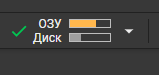



Для предотвращения переполнения ОЗУ может помочь библиотека `gc`. Вставьте строчку `gc.collect()` в цикл ваших экспериментов для сбора и удаления временных данных (кеш).

Перед выполнением задания, пожалуйста, запустите ячейку `Подготовка` ниже:

## Подготовка

### Импорт библиотек

In [1]:
 # Импортируем модели keras: Model
from tensorflow.keras.models import Model

 # Импортируем стандартные слои keras
from tensorflow.keras.layers import Input, Conv2DTranspose, concatenate, Activation
from tensorflow.keras.layers import MaxPooling2D, Conv2D, BatchNormalization, UpSampling2D

# Импортируем оптимизатор Adam
from tensorflow.keras.optimizers import Adam

# Импортируем модуль pyplot библиотеки matplotlib для построения графиков
import matplotlib.pyplot as plt

# Импортируем модуль image для работы с изображениями
from tensorflow.keras.preprocessing import image

# Импортируем библиотеку numpy
import numpy as np

# Импортируем методделения выборки
from sklearn.model_selection import train_test_split

# загрузка файлов по HTML ссылке
import gdown

# Для работы с файлами
import os

# Для генерации случайных чисел
import random

import time

# импортируем модель Image для работы с изображениями
from PIL import Image

# очистка ОЗУ
import gc

2025-05-25 12:52:16.126408: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748177536.338986      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748177536.400834      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


### Загрузка датасета

грузим и распаковываем архив картинок

In [2]:
# Глобальные параметры

IMG_WIDTH = 256               # Ширина картинки
IMG_HEIGHT = 192              # Высота картинки
NUM_CLASSES = 16              # Задаем количество классов на изображении
TRAIN_DIRECTORY = '/kaggle/input/construction-256x192/train'     # Название папки с файлами обучающей выборки
VAL_DIRECTORY = '/kaggle/input/construction-256x192/val'         # Название папки с файлами проверочной выборки

Загрузим оригинальные изображения (код из лекции):

In [3]:
train_images = [] # Создаем пустой список для хранений оригинальных изображений обучающей выборки
val_images = [] # Создаем пустой список для хранений оригинальных изображений проверочной выборки

cur_time = time.time()  # Засекаем текущее время

# Проходим по всем файлам в каталоге по указанному пути
for filename in sorted(os.listdir(TRAIN_DIRECTORY+'/original')):
    # Читаем очередную картинку и добавляем ее в список изображений с указанным target_size
    train_images.append(image.load_img(os.path.join(TRAIN_DIRECTORY+'/original',filename),
                                       target_size=(IMG_WIDTH, IMG_HEIGHT)))

# Отображаем время загрузки картинок обучающей выборки
print ('Обучающая выборка загружена. Время загрузки: ', round(time.time() - cur_time, 2), 'c', sep='')

# Отображаем количество элементов в обучающей выборке
print ('Количество изображений: ', len(train_images))

cur_time = time.time() # Засекаем текущее время

# Проходим по всем файлам в каталоге по указанному пути
for filename in sorted(os.listdir(VAL_DIRECTORY+'/original')):
    # Читаем очередную картинку и добавляем ее в список изображений с указанным target_size
    val_images.append(image.load_img(os.path.join(VAL_DIRECTORY+'/original',filename),
                                     target_size=(IMG_WIDTH, IMG_HEIGHT)))

# Отображаем время загрузки картинок проверочной выборки
print ('Проверочная выборка загружена. Время загрузки: ', round(time.time() - cur_time, 2), 'c', sep='')

# Отображаем количество элементов в проверочной выборке
print ('Количество изображений: ', len(val_images))

Обучающая выборка загружена. Время загрузки: 9.37c
Количество изображений:  1900
Проверочная выборка загружена. Время загрузки: 0.46c
Количество изображений:  100


Загрузим сегментированные изображения (код из лекции):

In [4]:
train_segments = [] # Создаем пустой список для хранений оригинальных изображений обучающей выборки
val_segments = [] # Создаем пустой список для хранений оригинальных изображений проверочной выборки

cur_time = time.time() # Засекаем текущее время

for filename in sorted(os.listdir(TRAIN_DIRECTORY+'/segment')): # Проходим по всем файлам в каталоге по указанному пути
    # Читаем очередную картинку и добавляем ее в список изображений с указанным target_size
    train_segments.append(image.load_img(os.path.join(TRAIN_DIRECTORY+'/segment',filename),
                                       target_size=(IMG_WIDTH, IMG_HEIGHT)))

# Отображаем время загрузки картинок обучающей выборки
print ('Обучающая выборка загружена. Время загрузки: ', round(time.time() - cur_time, 2), 'c', sep='')

# Отображаем количество элементов в обучающем наборе сегментированных изображений
print ('Количество изображений: ', len(train_segments))

cur_time = time.time() # Засекаем текущее время

for filename in sorted(os.listdir(VAL_DIRECTORY+'/segment')): # Проходим по всем файлам в каталоге по указанному пути
    # Читаем очередную картинку и добавляем ее в список изображений с указанным target_size
    val_segments.append(image.load_img(os.path.join(VAL_DIRECTORY+'/segment',filename),
                                     target_size=(IMG_WIDTH, IMG_HEIGHT)))

# Отображаем время загрузки картинок проверочной выборки
print ('Проверочная выборка загружена. Время загрузки: ', round(time.time() - cur_time, 2), 'c', sep='')

# Отображаем количество элементов в проверочном наборе сегментированных изображений
print ('Количество изображений: ', len(val_segments))

Обучающая выборка загружена. Время загрузки: 7.96c
Количество изображений:  1900
Проверочная выборка загружена. Время загрузки: 0.41c
Количество изображений:  100


## Решение


In [5]:
# Функция для обработки сегментов
def process_segment(segments):
    processed = []
    for seg in segments:
        seg_array = np.array(seg)
        if seg_array.ndim == 3:
            seg_array = seg_array[:, :, 0]  # Берем первый канал если изображение RGB
        seg_array = seg_array % NUM_CLASSES  # Преобразуем метки в диапазон 0-4
        processed.append(seg_array)
    return processed

# Обработка сегментов
train_segments = process_segment(train_segments)
val_segments = process_segment(val_segments)

# Преобразование изображений и меток в numpy массивы
X_train = np.array([image.img_to_array(img)/255.0 for img in train_images])
y_train = np.array([seg for seg in train_segments], dtype=np.uint8)
X_val = np.array([image.img_to_array(img)/255.0 for img in val_images])
y_val = np.array([seg for seg in val_segments], dtype=np.uint8)

In [6]:
# Модифицированная модель U-Net с полной параметризацией
def masked_unet(class_count, input_shape, filters_list, kernel_size=(3,3), activation='relu'):
    img_input = Input(input_shape)
    # (Чтобы опять всё не легло!) Добавлена проверка kernel_size
    if isinstance(kernel_size, list):
        assert len(kernel_size) == 5, "kernel_size list must have 5 elements"
    else:
        kernel_size = [kernel_size]*5
    # Block 1
    x = Conv2D(filters_list[0], kernel_size[0], padding='same', name='block1_conv1')(img_input)
    x = BatchNormalization()(x)
    x = Activation(activation)(x)
    x = Conv2D(filters_list[0], kernel_size[0], padding='same', name='block1_conv2')(x)
    x = BatchNormalization()(x)
    block_1_out = Activation(activation)(x)
    block_1_out_mask = Conv2D(filters_list[0], (1,1), padding='same')(block_1_out)
    x = MaxPooling2D()(block_1_out)

    # Block 2
    x = Conv2D(filters_list[1], kernel_size[1], padding='same', name='block2_conv1')(x)
    x = BatchNormalization()(x)
    x = Activation(activation)(x)
    x = Conv2D(filters_list[1], kernel_size[1], padding='same', name='block2_conv2')(x)
    x = BatchNormalization()(x)
    block_2_out = Activation(activation)(x)
    block_2_out_mask = Conv2D(filters_list[1], (1,1), padding='same')(block_2_out)
    x = MaxPooling2D()(block_2_out)

    # Block 3
    x = Conv2D(filters_list[2], kernel_size[2], padding='same', name='block3_conv1')(x)
    x = BatchNormalization()(x)
    x = Activation(activation)(x)
    x = Conv2D(filters_list[2], kernel_size[2], padding='same', name='block3_conv2')(x)
    x = BatchNormalization()(x)
    block_3_out = Activation(activation)(x)
    block_3_out_mask = Conv2D(filters_list[2], (1,1), padding='same')(block_3_out)
    x = MaxPooling2D()(block_3_out)

    # Block 4
    x = Conv2D(filters_list[3], kernel_size[3], padding='same', name='block4_conv1')(x)
    x = BatchNormalization()(x)
    x = Activation(activation)(x)
    x = Conv2D(filters_list[3], kernel_size[3], padding='same', name='block4_conv2')(x)
    x = BatchNormalization()(x)
    block_4_out = Activation(activation)(x)
    block_4_out_mask = Conv2D(filters_list[3], (1,1), padding='same')(block_4_out)
    x = MaxPooling2D()(block_4_out)

    # Block 5
    x = Conv2D(filters_list[4], kernel_size[4], padding='same', name='block5_conv1')(x)
    x = BatchNormalization()(x)
    x = Activation(activation)(x)
    x = Conv2D(filters_list[4], kernel_size[4], padding='same', name='block5_conv2')(x)
    x = BatchNormalization()(x)
    x = Activation(activation)(x)

    # Декодинг
    # UP 1
    x = Conv2DTranspose(filters_list[3], (2,2), strides=(2,2), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation(activation)(x)
    x = concatenate([x, block_4_out, block_4_out_mask])
    x = Conv2D(filters_list[3], kernel_size[3], padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation(activation)(x)

    # UP 2
    x = Conv2DTranspose(filters_list[2], (2,2), strides=(2,2), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation(activation)(x)
    x = concatenate([x, block_3_out, block_3_out_mask])
    x = Conv2D(filters_list[2], kernel_size[2], padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation(activation)(x)

    # UP 3
    x = Conv2DTranspose(filters_list[1], (2,2), strides=(2,2), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation(activation)(x)
    x = concatenate([x, block_2_out, block_2_out_mask])
    x = Conv2D(filters_list[1], kernel_size[1], padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation(activation)(x)

    # UP 4
    x = Conv2DTranspose(filters_list[0], (2,2), strides=(2,2), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation(activation)(x)
    x = concatenate([x, block_1_out, block_1_out_mask])
    x = Conv2D(filters_list[0], kernel_size[0], padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation(activation)(x)

    # Последний слой
    x = Conv2D(class_count, (3,3), activation='softmax', padding='same')(x)

    model = Model(img_input, x)
    model.compile(optimizer=Adam(learning_rate=1e-3),
                 loss='sparse_categorical_crossentropy',
                 metrics=['sparse_categorical_accuracy'])
    return model

In [7]:
experiments = [
    # Базовый вариант (оригинальные параметры)
    {'name': 'Basic',
     'filters': [64, 128, 256, 512, 512],
     'kernel_size': (3,3),
     'activation': 'relu'},

    # Уменьшен kernel
    {'name': 'Kernel 1,1',
     'filters': [64, 128, 256, 512, 512],
     'kernel_size': (1,1),
     'activation': 'relu'},

    # Линейная активация
    {'name': 'Linear',
     'filters': [64, 128, 256, 512, 512],
     'kernel_size': (3,3),
     'activation': 'linear'},

    # Фильтры в 2 раза больше
    {'name': 'Filters*2',
     'filters': [128, 256, 512, 1024, 1024],
     'kernel_size': (3,3),
     'activation': 'relu'},

    # Фильтры в 2 раза меньше. При сохранении весов из-за / была ошибка
    {'name': 'Filters_del_2',
     'filters': [32, 64, 128, 256, 256],
     'kernel_size': (3,3),
     'activation': 'relu'},

    # Увеличен kernel
    {'name': 'Kernel 5, 5',
     'filters': [64, 128, 256, 512, 512],
     'kernel_size': (5,5),
     'activation': 'relu'},

    # SELU активация
    {'name': 'SELU',
     'filters': [64, 128, 256, 512, 512],
     'kernel_size': (3,3),
     'activation': 'selu'},

    # ELU активация
    {'name': 'ELU',
     'filters': [64, 128, 256, 512, 512],
     'kernel_size': (3,3),
     'activation': 'elu'},

    # Много разных kernel_size
    {'name': 'Kernel_sizes',
     'filters': [64, 128, 256, 512, 512],
     'kernel_size': [(5,5), (3,3), (3,3), (1,1), (1,1)],
     'activation': 'relu'},

    # Kernel 5x5 и ELU
    {'name': 'Kernel 5,5 и ELU',
     'filters': [64, 128, 256, 512, 512],
     'kernel_size': (5,5),
     'activation': 'elu'},

    # Удвоенные фильтры и SELU
    {'name': 'Filters*2 и SELU',
     'filters': [128, 256, 512, 1024, 1024],
     'kernel_size': (3,3),
     'activation': 'selu'}

]


Starting experiment: Basic
Parameters: filters=[64, 128, 256, 512, 512], kernel=(3, 3), activation=relu
Epoch 1/7
238/238 ━━━━━━━━━━━━━━━━━━━━ 131s 448ms/step - loss: 0.9347 - sparse_categorical_accuracy: 0.6574 - val_loss: 1.2600 - val_sparse_categorical_accuracy: 0.7091
Epoch 2/7
238/238 ━━━━━━━━━━━━━━━━━━━━ 116s 391ms/step - loss: 0.5928 - sparse_categorical_accuracy: 0.7676 - val_loss: 0.7469 - val_sparse_categorical_accuracy: 0.7254
Epoch 3/7
238/238 ━━━━━━━━━━━━━━━━━━━━ 142s 391ms/step - loss: 0.5288 - sparse_categorical_accuracy: 0.7937 - val_loss: 0.7587 - val_sparse_categorical_accuracy: 0.7160
Epoch 4/7
238/238 ━━━━━━━━━━━━━━━━━━━━ 142s 392ms/step - loss: 0.5010 - sparse_categorical_accuracy: 0.8067 - val_loss: 0.9889 - val_sparse_categorical_accuracy: 0.6193
Epoch 5/7
238/238 ━━━━━━━━━━━━━━━━━━━━ 141s 388ms/step - loss: 0.4789 - sparse_categorical_accuracy: 0.8168 - val_loss: 0.9298 - val_sparse_categorical_accuracy: 0.5981
Epoch 6/7
238/238 ━━━━━━━━━━━━━━━━━━━━ 143s 392ms/

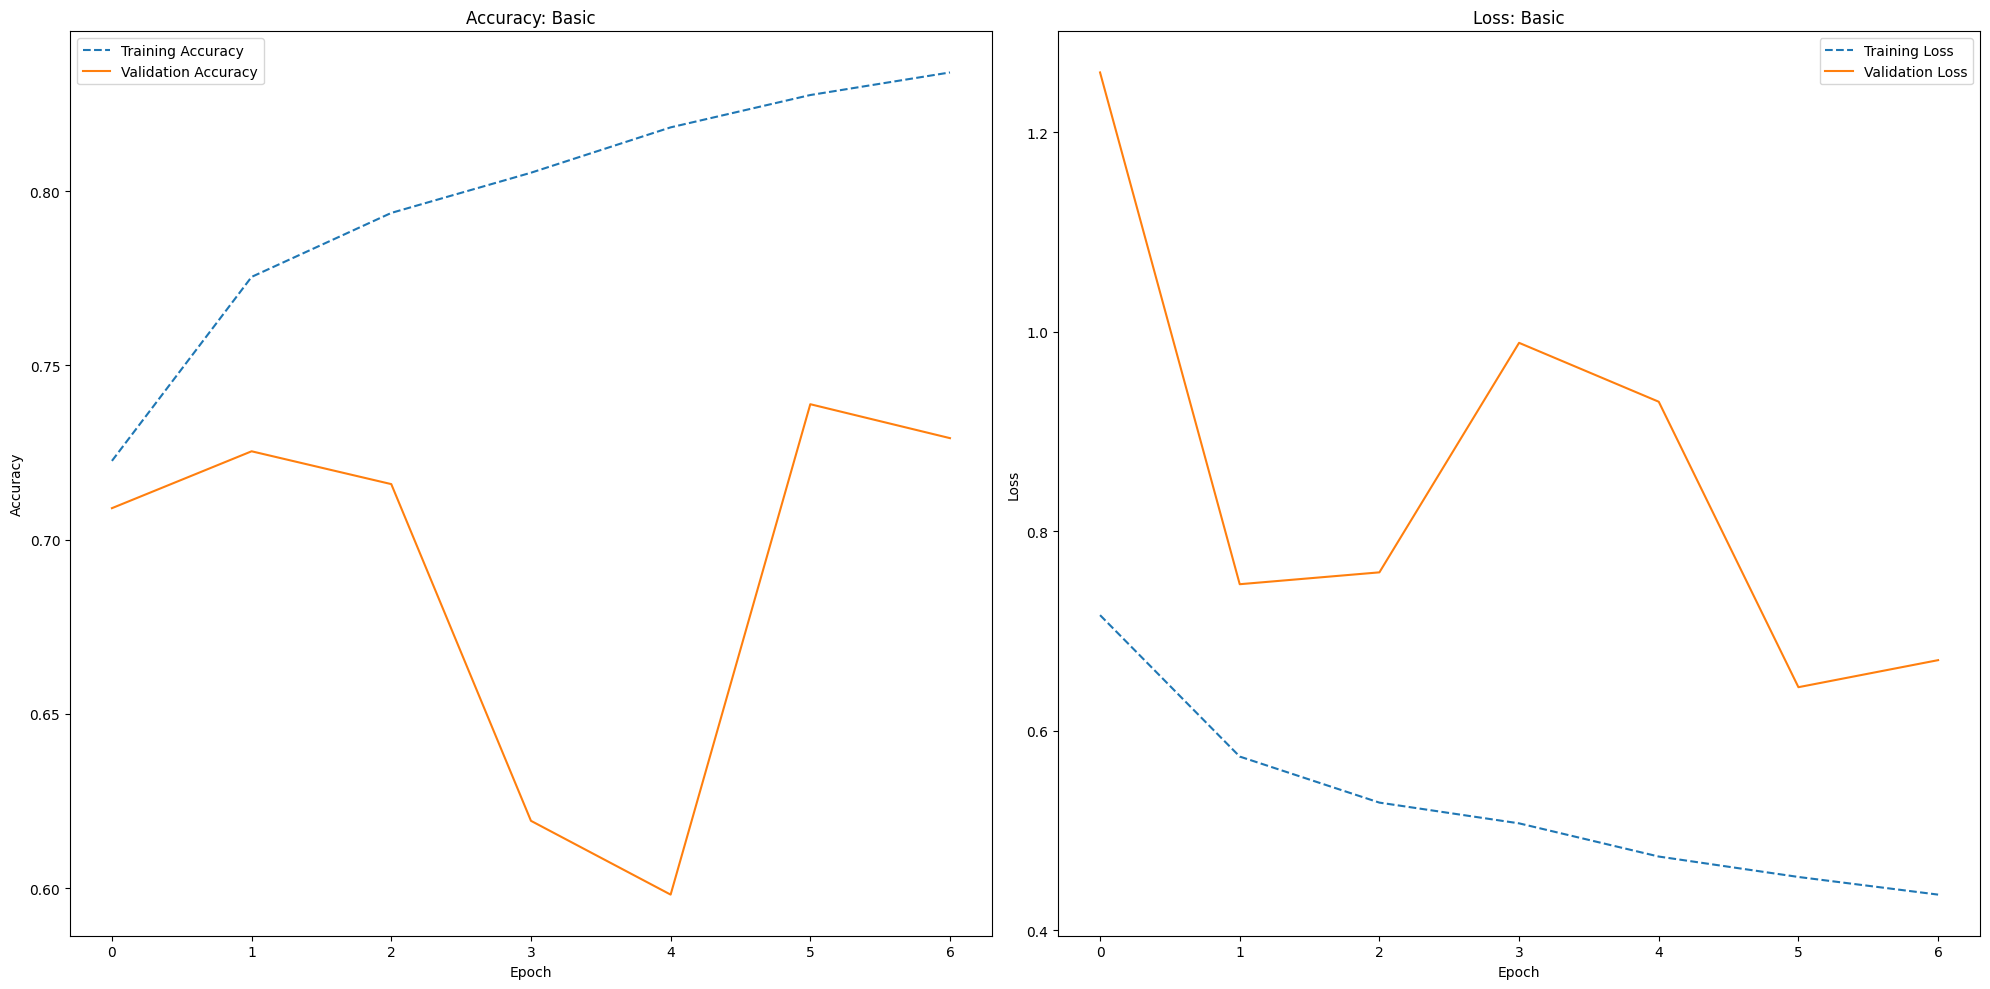

Experiment Basic completed.


Starting experiment: Kernel 1,1
Parameters: filters=[64, 128, 256, 512, 512], kernel=(1, 1), activation=relu
Epoch 1/7
238/238 ━━━━━━━━━━━━━━━━━━━━ 91s 251ms/step - loss: 0.9788 - sparse_categorical_accuracy: 0.6349 - val_loss: 1.5540 - val_sparse_categorical_accuracy: 0.6410
Epoch 2/7
238/238 ━━━━━━━━━━━━━━━━━━━━ 40s 167ms/step - loss: 0.7316 - sparse_categorical_accuracy: 0.6894 - val_loss: 0.9159 - val_sparse_categorical_accuracy: 0.6067
Epoch 3/7
238/238 ━━━━━━━━━━━━━━━━━━━━ 40s 166ms/step - loss: 0.7100 - sparse_categorical_accuracy: 0.6961 - val_loss: 0.8728 - val_sparse_categorical_accuracy: 0.6012
Epoch 4/7
238/238 ━━━━━━━━━━━━━━━━━━━━ 41s 165ms/step - loss: 0.6905 - sparse_categorical_accuracy: 0.7076 - val_loss: 0.8706 - val_sparse_categorical_accuracy: 0.5881
Epoch 5/7
238/238 ━━━━━━━━━━━━━━━━━━━━ 39s 165ms/step - loss: 0.6627 - sparse_categorical_accuracy: 0.7198 - val_loss: 0.8696 - val_sparse_categorical_accuracy: 0.5871
Epoch 6/7
238/238 ━━━

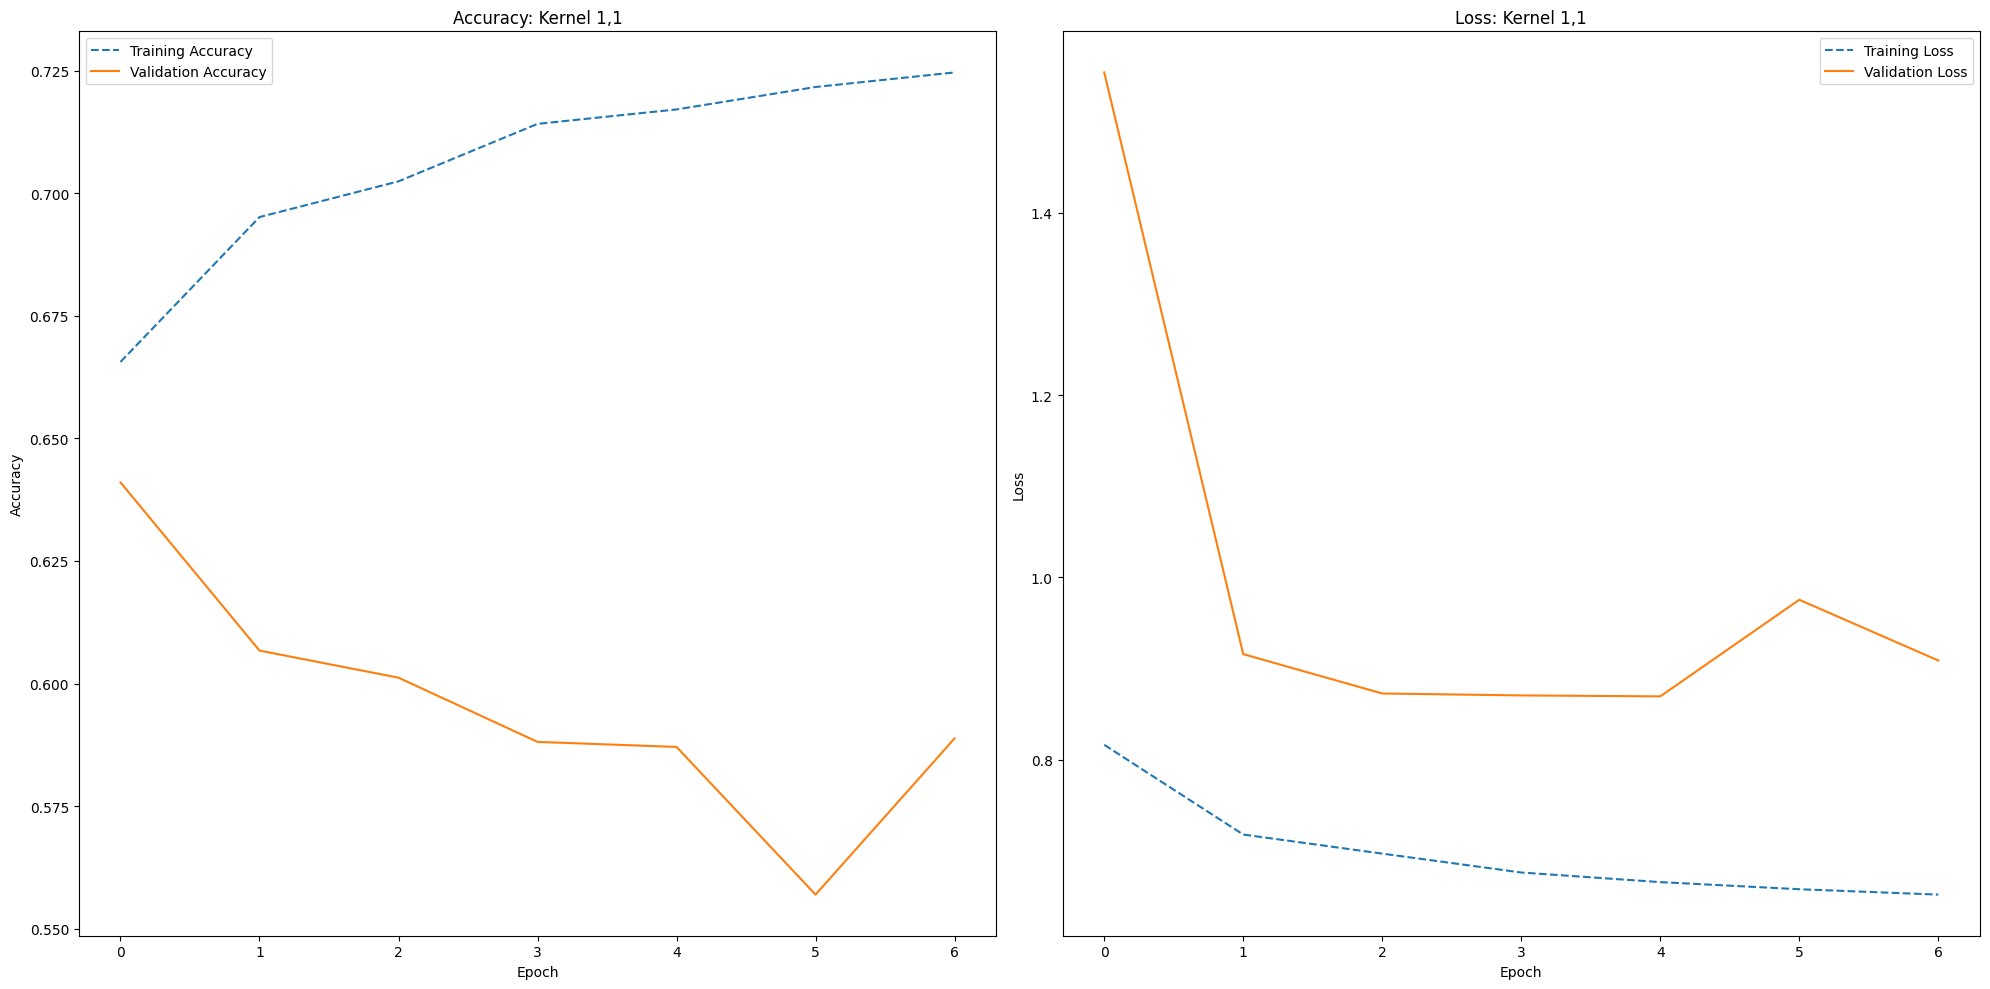

Experiment Kernel 1,1 completed.


Starting experiment: Linear
Parameters: filters=[64, 128, 256, 512, 512], kernel=(3, 3), activation=linear
Epoch 1/7
238/238 ━━━━━━━━━━━━━━━━━━━━ 127s 441ms/step - loss: 1.9402 - sparse_categorical_accuracy: 0.5249 - val_loss: 0.8758 - val_sparse_categorical_accuracy: 0.7103
Epoch 2/7
238/238 ━━━━━━━━━━━━━━━━━━━━ 92s 387ms/step - loss: 0.6775 - sparse_categorical_accuracy: 0.7418 - val_loss: 0.8185 - val_sparse_categorical_accuracy: 0.7110
Epoch 3/7
238/238 ━━━━━━━━━━━━━━━━━━━━ 142s 387ms/step - loss: 0.6331 - sparse_categorical_accuracy: 0.7561 - val_loss: 0.9382 - val_sparse_categorical_accuracy: 0.6474
Epoch 4/7
238/238 ━━━━━━━━━━━━━━━━━━━━ 142s 387ms/step - loss: 0.6136 - sparse_categorical_accuracy: 0.7640 - val_loss: 0.8960 - val_sparse_categorical_accuracy: 0.6917
Epoch 5/7
238/238 ━━━━━━━━━━━━━━━━━━━━ 143s 390ms/step - loss: 0.6145 - sparse_categorical_accuracy: 0.7648 - val_loss: 0.8260 - val_sparse_categorical_accuracy: 0.7198
Epoch 6/7
238/

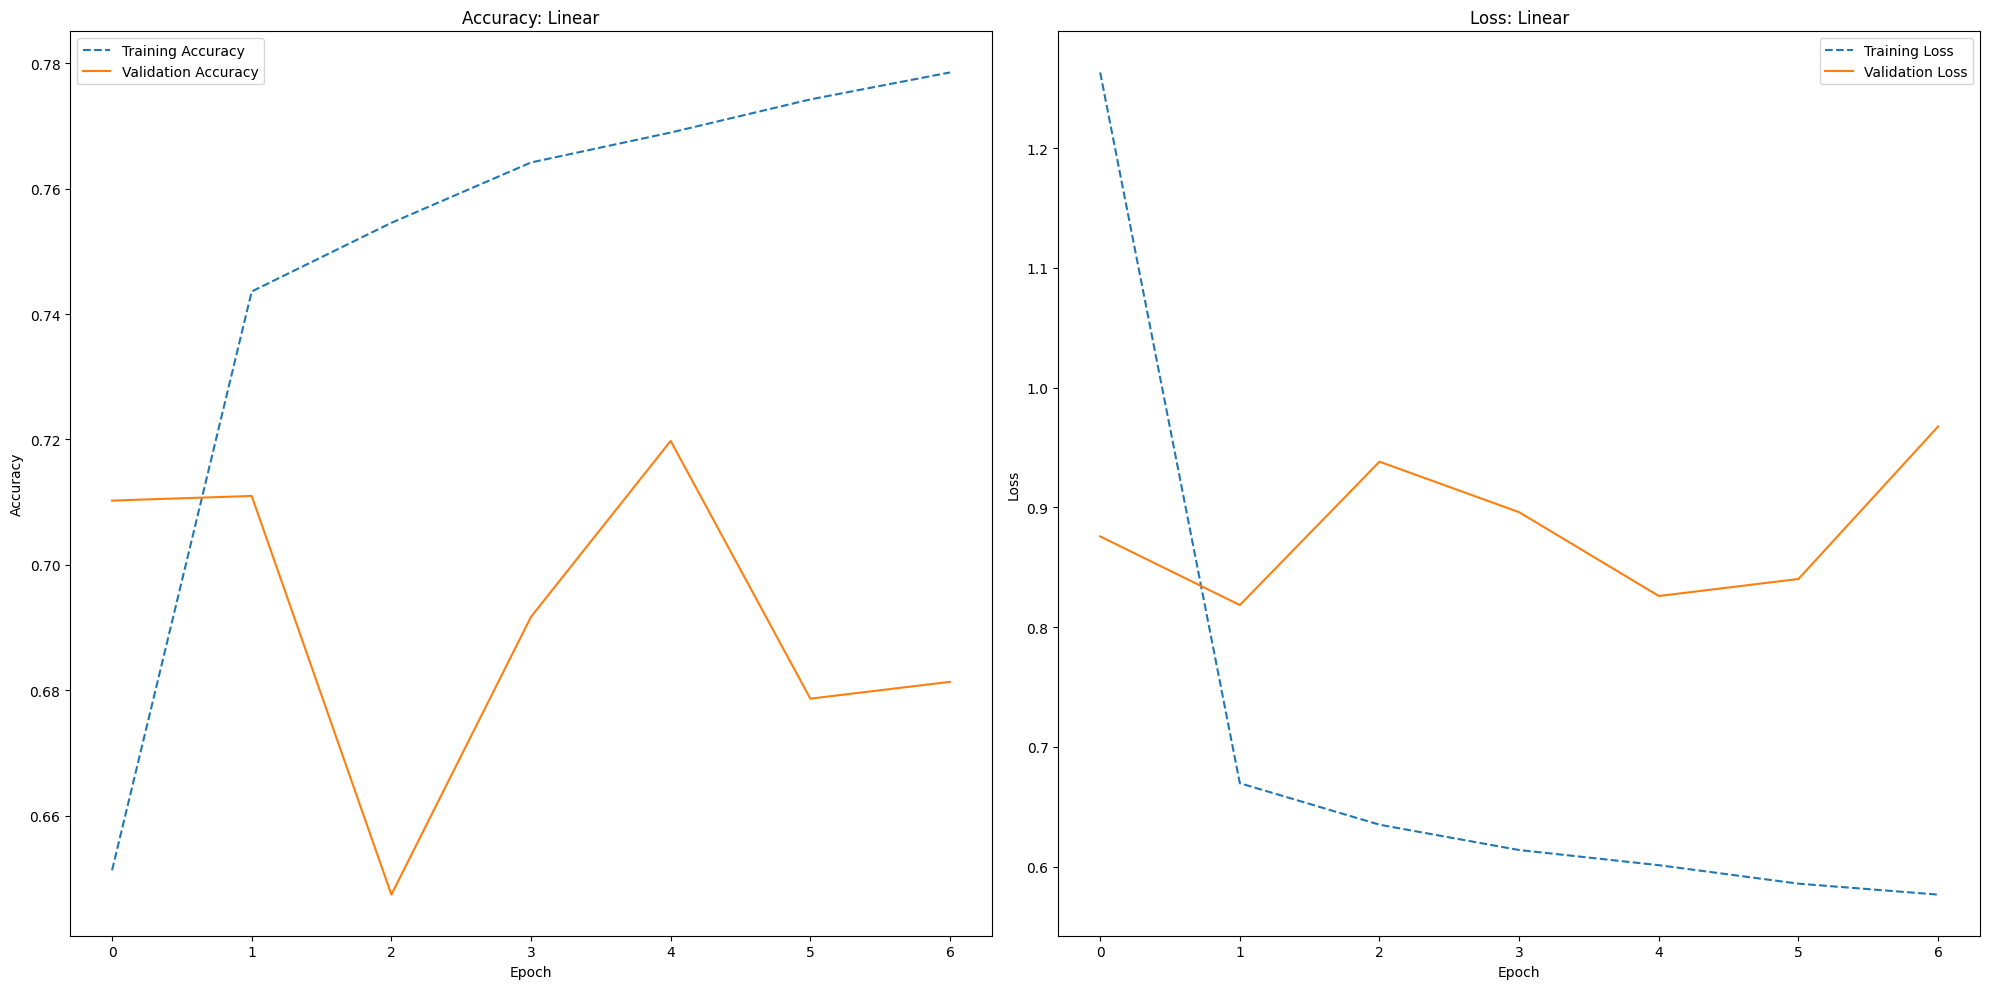

Experiment Linear completed.


Starting experiment: Filters*2
Parameters: filters=[128, 256, 512, 1024, 1024], kernel=(3, 3), activation=relu
Epoch 1/7
238/238 ━━━━━━━━━━━━━━━━━━━━ 477s 2s/step - loss: 0.9181 - sparse_categorical_accuracy: 0.6564 - val_loss: 0.9216 - val_sparse_categorical_accuracy: 0.6767
Epoch 2/7
238/238 ━━━━━━━━━━━━━━━━━━━━ 293s 1s/step - loss: 0.6463 - sparse_categorical_accuracy: 0.7447 - val_loss: 1.0608 - val_sparse_categorical_accuracy: 0.5894
Epoch 3/7
238/238 ━━━━━━━━━━━━━━━━━━━━ 322s 1s/step - loss: 0.5988 - sparse_categorical_accuracy: 0.7625 - val_loss: 0.7252 - val_sparse_categorical_accuracy: 0.7166
Epoch 4/7
238/238 ━━━━━━━━━━━━━━━━━━━━ 322s 1s/step - loss: 0.5378 - sparse_categorical_accuracy: 0.7922 - val_loss: 0.6980 - val_sparse_categorical_accuracy: 0.7045
Epoch 5/7
238/238 ━━━━━━━━━━━━━━━━━━━━ 322s 1s/step - loss: 0.5036 - sparse_categorical_accuracy: 0.8075 - val_loss: 0.7644 - val_sparse_categorical_accuracy: 0.6854
Epoch 6/7
238/238 ━━━━━━━━━━

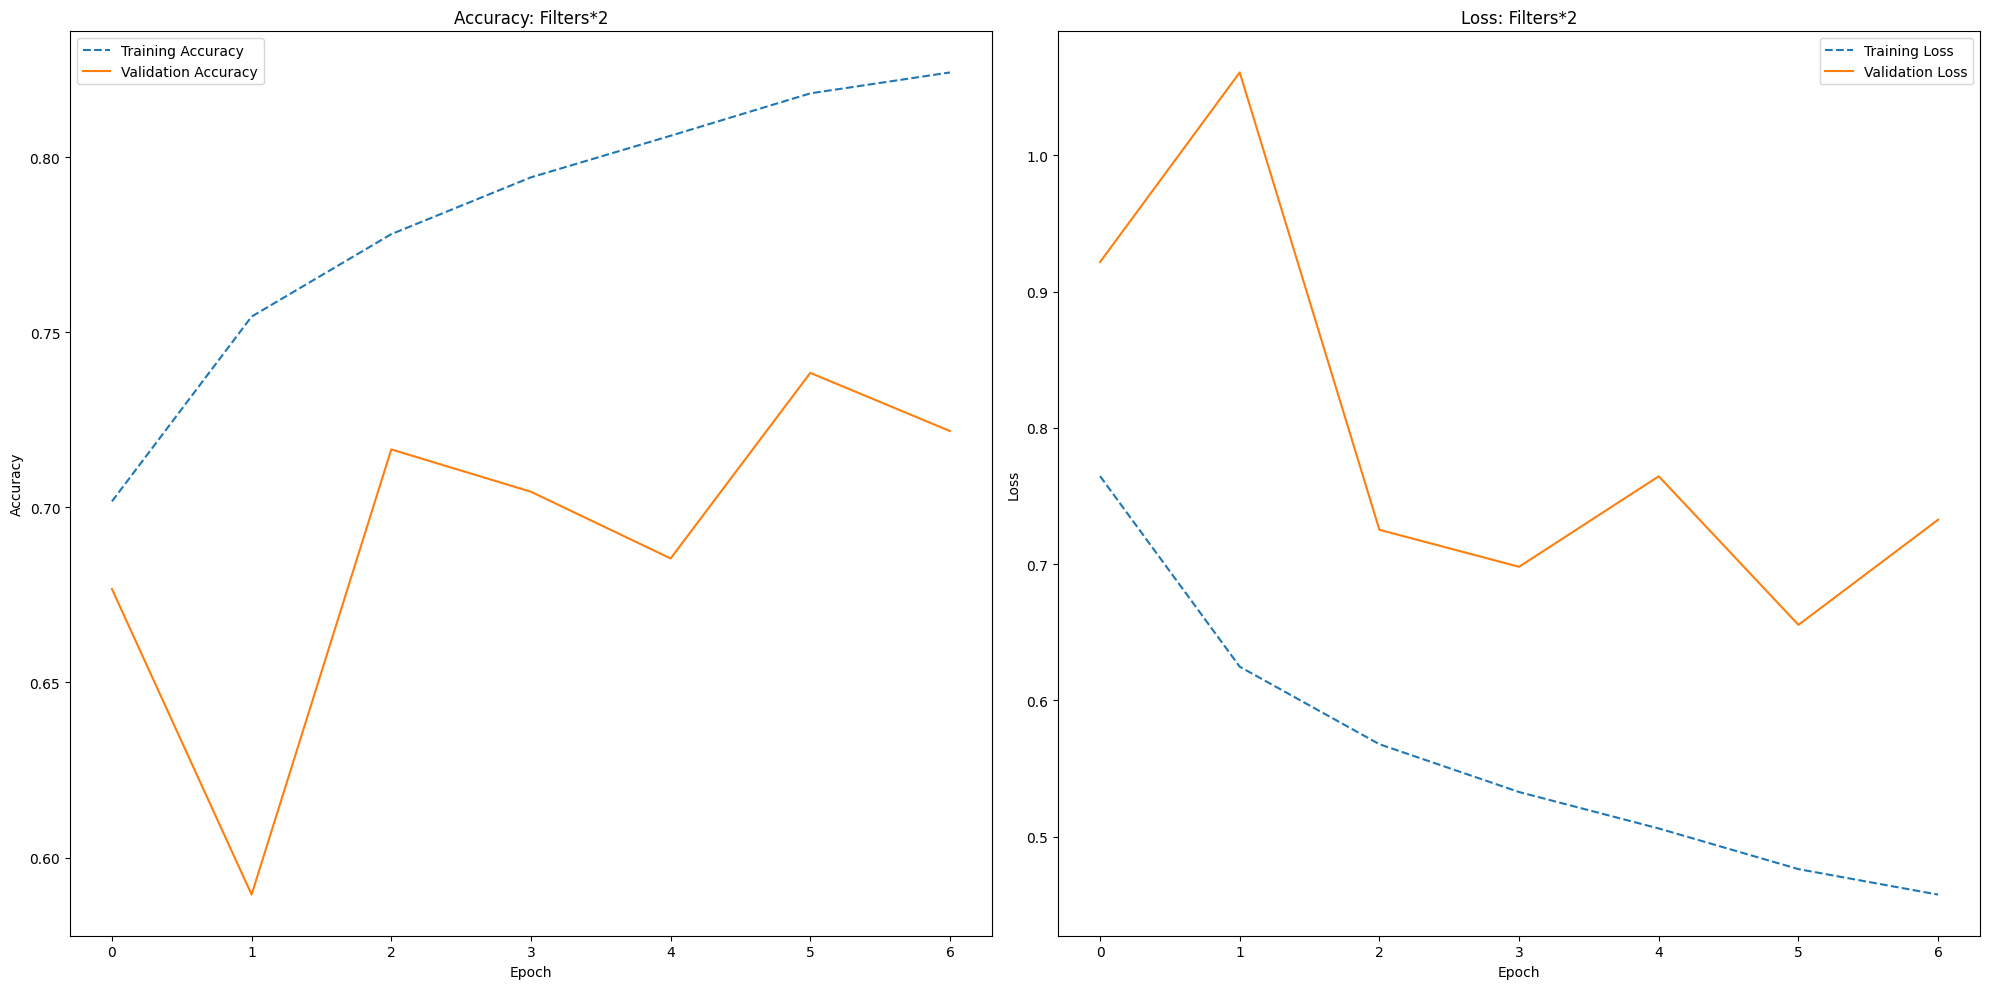

Experiment Filters*2 completed.


Starting experiment: Filters_del_2
Parameters: filters=[32, 64, 128, 256, 256], kernel=(3, 3), activation=relu
Epoch 1/7
238/238 ━━━━━━━━━━━━━━━━━━━━ 97s 243ms/step - loss: 1.0075 - sparse_categorical_accuracy: 0.6673 - val_loss: 1.3435 - val_sparse_categorical_accuracy: 0.5057
Epoch 2/7
238/238 ━━━━━━━━━━━━━━━━━━━━ 32s 136ms/step - loss: 0.5623 - sparse_categorical_accuracy: 0.7823 - val_loss: 0.7669 - val_sparse_categorical_accuracy: 0.7212
Epoch 3/7
238/238 ━━━━━━━━━━━━━━━━━━━━ 41s 135ms/step - loss: 0.5218 - sparse_categorical_accuracy: 0.7971 - val_loss: 0.9083 - val_sparse_categorical_accuracy: 0.6834
Epoch 4/7
238/238 ━━━━━━━━━━━━━━━━━━━━ 41s 135ms/step - loss: 0.4947 - sparse_categorical_accuracy: 0.8121 - val_loss: 0.7369 - val_sparse_categorical_accuracy: 0.7092
Epoch 5/7
238/238 ━━━━━━━━━━━━━━━━━━━━ 41s 137ms/step - loss: 0.4577 - sparse_categorical_accuracy: 0.8252 - val_loss: 0.7266 - val_sparse_categorical_accuracy: 0.7001
Epoch 6/7
238/2

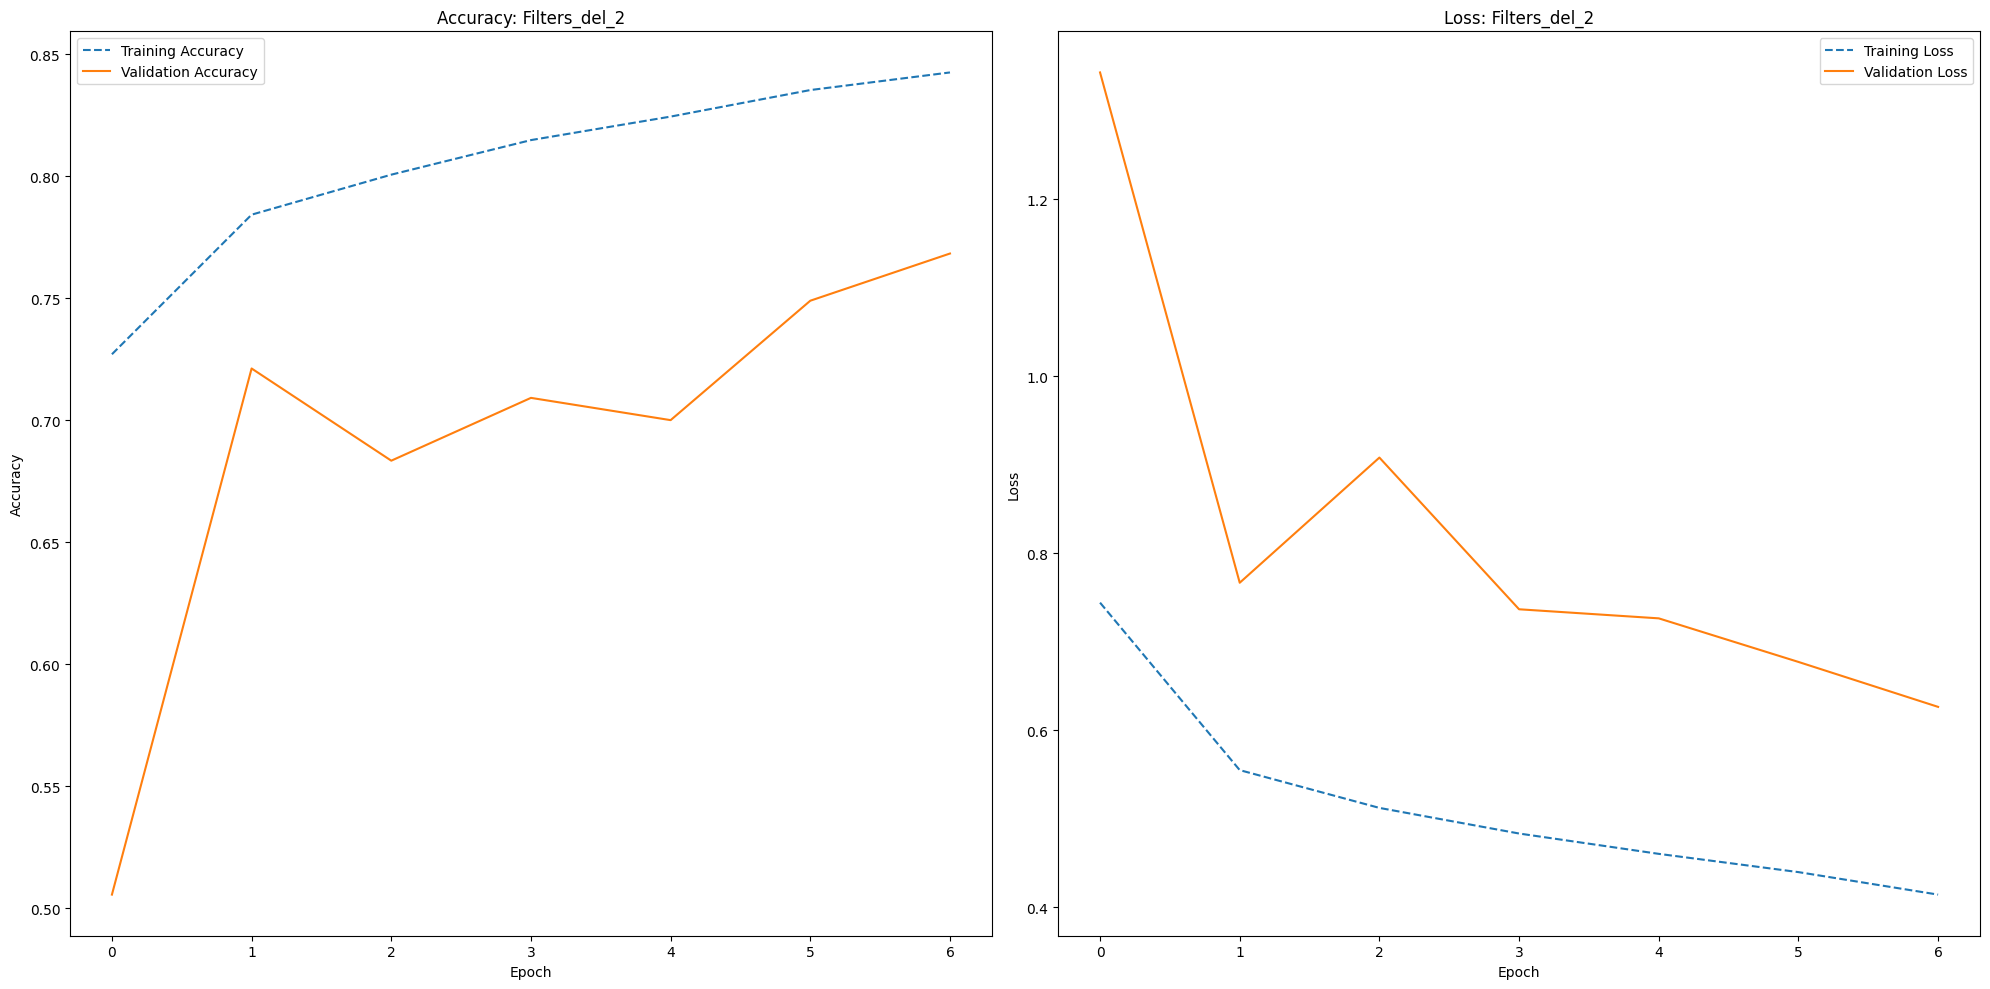

Experiment Filters_del_2 completed.


Starting experiment: Kernel 5, 5
Parameters: filters=[64, 128, 256, 512, 512], kernel=(5, 5), activation=relu
Epoch 1/7
238/238 ━━━━━━━━━━━━━━━━━━━━ 297s 928ms/step - loss: 0.9730 - sparse_categorical_accuracy: 0.6545 - val_loss: 1.0410 - val_sparse_categorical_accuracy: 0.6643
Epoch 2/7
238/238 ━━━━━━━━━━━━━━━━━━━━ 212s 736ms/step - loss: 0.6180 - sparse_categorical_accuracy: 0.7546 - val_loss: 0.7852 - val_sparse_categorical_accuracy: 0.7359
Epoch 3/7
238/238 ━━━━━━━━━━━━━━━━━━━━ 176s 737ms/step - loss: 0.5778 - sparse_categorical_accuracy: 0.7789 - val_loss: 0.6745 - val_sparse_categorical_accuracy: 0.7388
Epoch 4/7
238/238 ━━━━━━━━━━━━━━━━━━━━ 174s 733ms/step - loss: 0.5244 - sparse_categorical_accuracy: 0.8008 - val_loss: 0.7668 - val_sparse_categorical_accuracy: 0.7381
Epoch 5/7
238/238 ━━━━━━━━━━━━━━━━━━━━ 176s 738ms/step - loss: 0.5021 - sparse_categorical_accuracy: 0.8110 - val_loss: 1.0068 - val_sparse_categorical_accuracy: 0.5764
Epoch 6

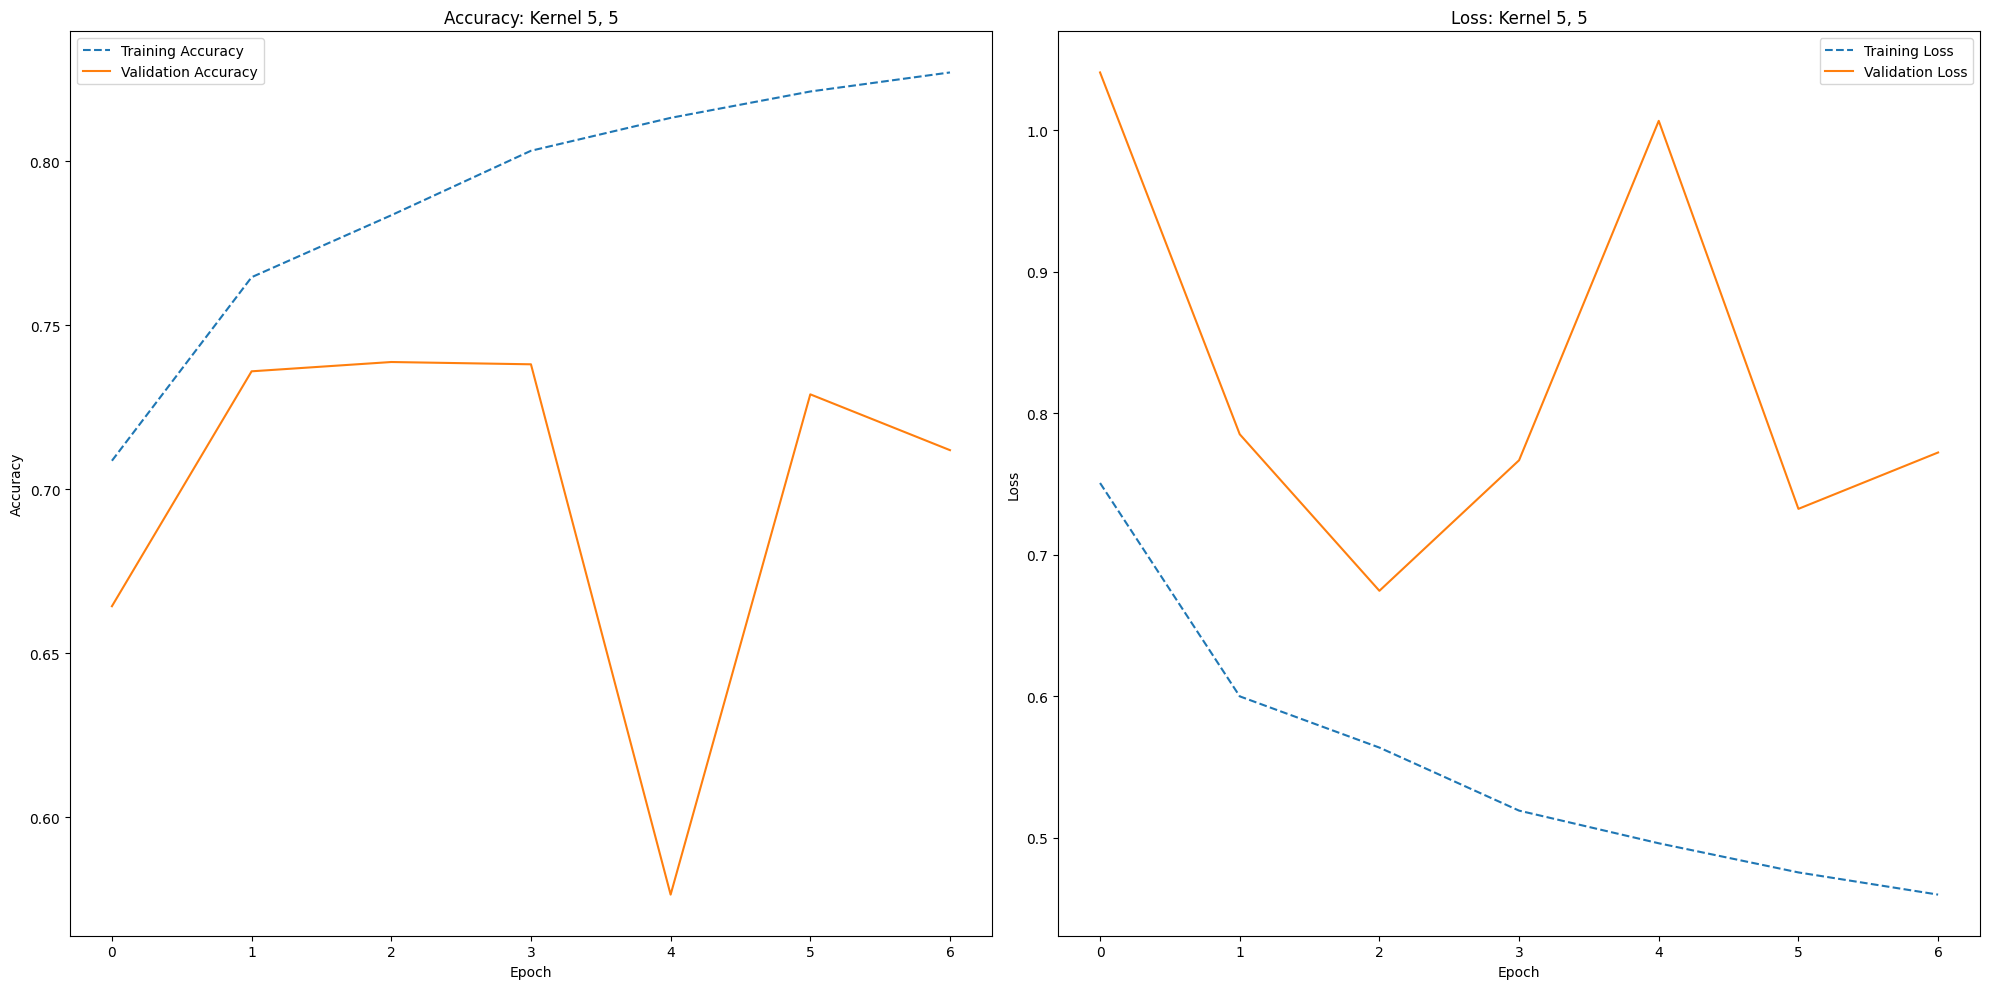

Experiment Kernel 5, 5 completed.


Starting experiment: SELU
Parameters: filters=[64, 128, 256, 512, 512], kernel=(3, 3), activation=selu
Epoch 1/7
238/238 ━━━━━━━━━━━━━━━━━━━━ 132s 455ms/step - loss: 1.8657 - sparse_categorical_accuracy: 0.5253 - val_loss: 1.7142 - val_sparse_categorical_accuracy: 0.4406
Epoch 2/7
238/238 ━━━━━━━━━━━━━━━━━━━━ 117s 399ms/step - loss: 0.6611 - sparse_categorical_accuracy: 0.7426 - val_loss: 0.9489 - val_sparse_categorical_accuracy: 0.6568
Epoch 3/7
238/238 ━━━━━━━━━━━━━━━━━━━━ 94s 397ms/step - loss: 0.6229 - sparse_categorical_accuracy: 0.7568 - val_loss: 0.7534 - val_sparse_categorical_accuracy: 0.7214
Epoch 4/7
238/238 ━━━━━━━━━━━━━━━━━━━━ 142s 395ms/step - loss: 0.5988 - sparse_categorical_accuracy: 0.7652 - val_loss: 0.7662 - val_sparse_categorical_accuracy: 0.6990
Epoch 5/7
238/238 ━━━━━━━━━━━━━━━━━━━━ 95s 397ms/step - loss: 0.5560 - sparse_categorical_accuracy: 0.7848 - val_loss: 0.7669 - val_sparse_categorical_accuracy: 0.6990
Epoch 6/7
238/238 

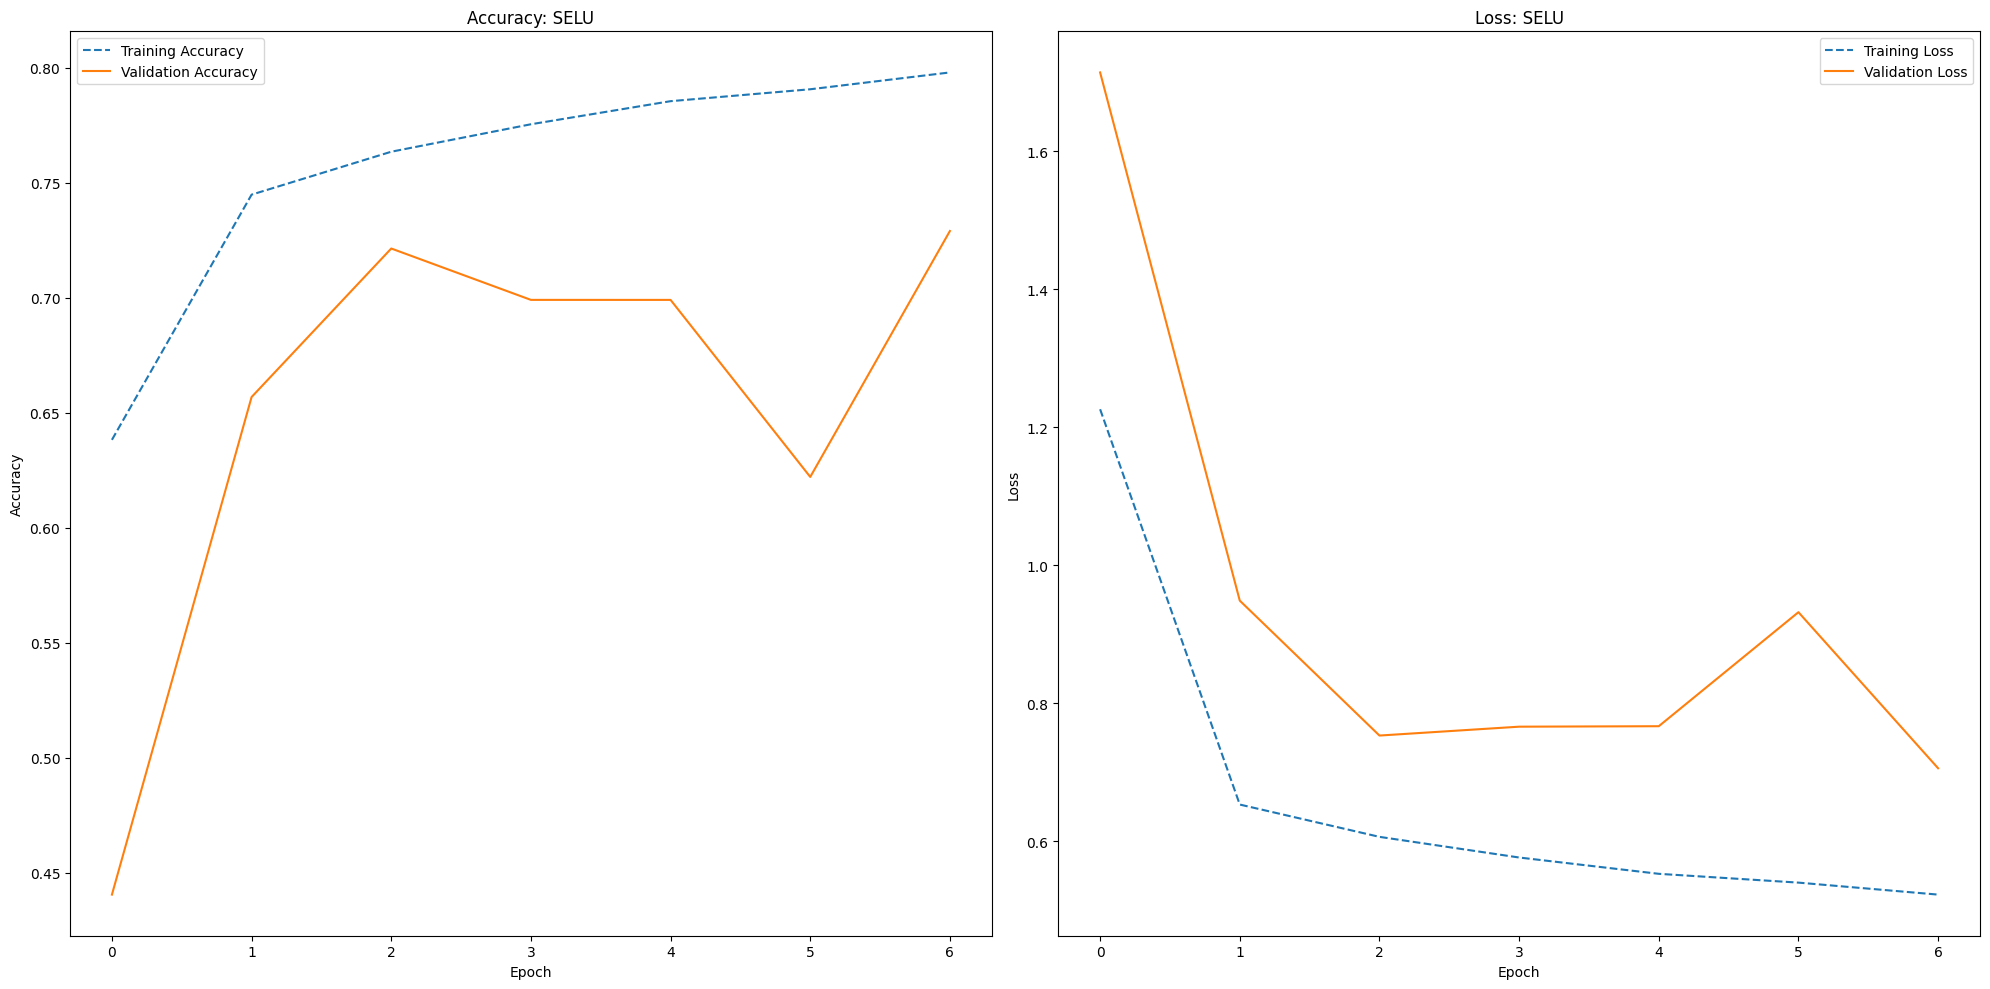

Experiment SELU completed.


Starting experiment: ELU
Parameters: filters=[64, 128, 256, 512, 512], kernel=(3, 3), activation=elu
Epoch 1/7
238/238 ━━━━━━━━━━━━━━━━━━━━ 132s 457ms/step - loss: 1.1656 - sparse_categorical_accuracy: 0.6431 - val_loss: 1.2752 - val_sparse_categorical_accuracy: 0.7072
Epoch 2/7
238/238 ━━━━━━━━━━━━━━━━━━━━ 116s 394ms/step - loss: 0.6382 - sparse_categorical_accuracy: 0.7528 - val_loss: 0.8628 - val_sparse_categorical_accuracy: 0.6839
Epoch 3/7
238/238 ━━━━━━━━━━━━━━━━━━━━ 94s 396ms/step - loss: 0.6003 - sparse_categorical_accuracy: 0.7665 - val_loss: 0.9487 - val_sparse_categorical_accuracy: 0.7041
Epoch 4/7
238/238 ━━━━━━━━━━━━━━━━━━━━ 142s 394ms/step - loss: 0.5548 - sparse_categorical_accuracy: 0.7864 - val_loss: 0.9517 - val_sparse_categorical_accuracy: 0.6128
Epoch 5/7
238/238 ━━━━━━━━━━━━━━━━━━━━ 143s 398ms/step - loss: 0.5240 - sparse_categorical_accuracy: 0.7989 - val_loss: 1.6673 - val_sparse_categorical_accuracy: 0.3839
Epoch 6/7
238/238 ━━━━━━━━

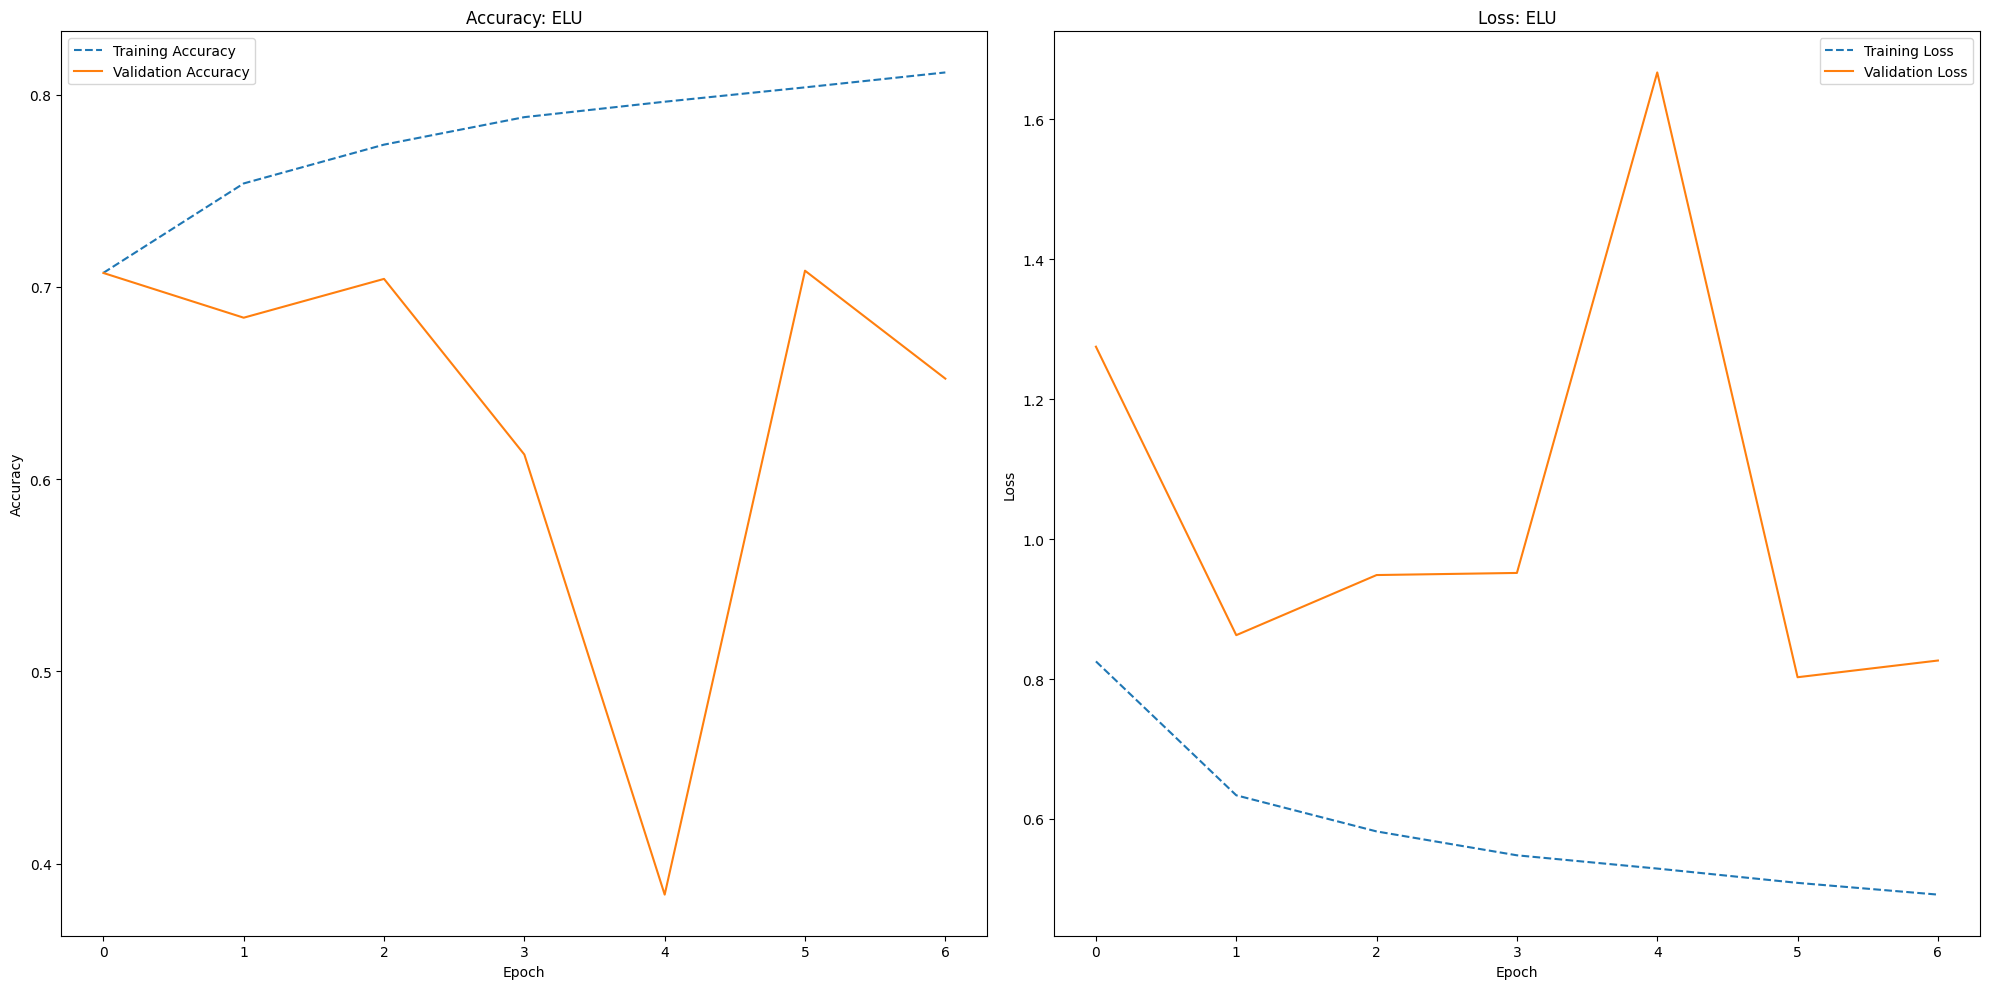

Experiment ELU completed.


Starting experiment: Kernel_sizes
Parameters: filters=[64, 128, 256, 512, 512], kernel=[(5, 5), (3, 3), (3, 3), (1, 1), (1, 1)], activation=relu
Epoch 1/7
238/238 ━━━━━━━━━━━━━━━━━━━━ 135s 465ms/step - loss: 0.9700 - sparse_categorical_accuracy: 0.6318 - val_loss: 0.9295 - val_sparse_categorical_accuracy: 0.6227
Epoch 2/7
238/238 ━━━━━━━━━━━━━━━━━━━━ 98s 412ms/step - loss: 0.7061 - sparse_categorical_accuracy: 0.7159 - val_loss: 0.9359 - val_sparse_categorical_accuracy: 0.5870
Epoch 3/7
238/238 ━━━━━━━━━━━━━━━━━━━━ 142s 412ms/step - loss: 0.6726 - sparse_categorical_accuracy: 0.7268 - val_loss: 0.9251 - val_sparse_categorical_accuracy: 0.6265
Epoch 4/7
238/238 ━━━━━━━━━━━━━━━━━━━━ 141s 409ms/step - loss: 0.6341 - sparse_categorical_accuracy: 0.7410 - val_loss: 0.9886 - val_sparse_categorical_accuracy: 0.6041
Epoch 5/7
238/238 ━━━━━━━━━━━━━━━━━━━━ 142s 410ms/step - loss: 0.5972 - sparse_categorical_accuracy: 0.7578 - val_loss: 0.7837 - val_sparse_categorical_

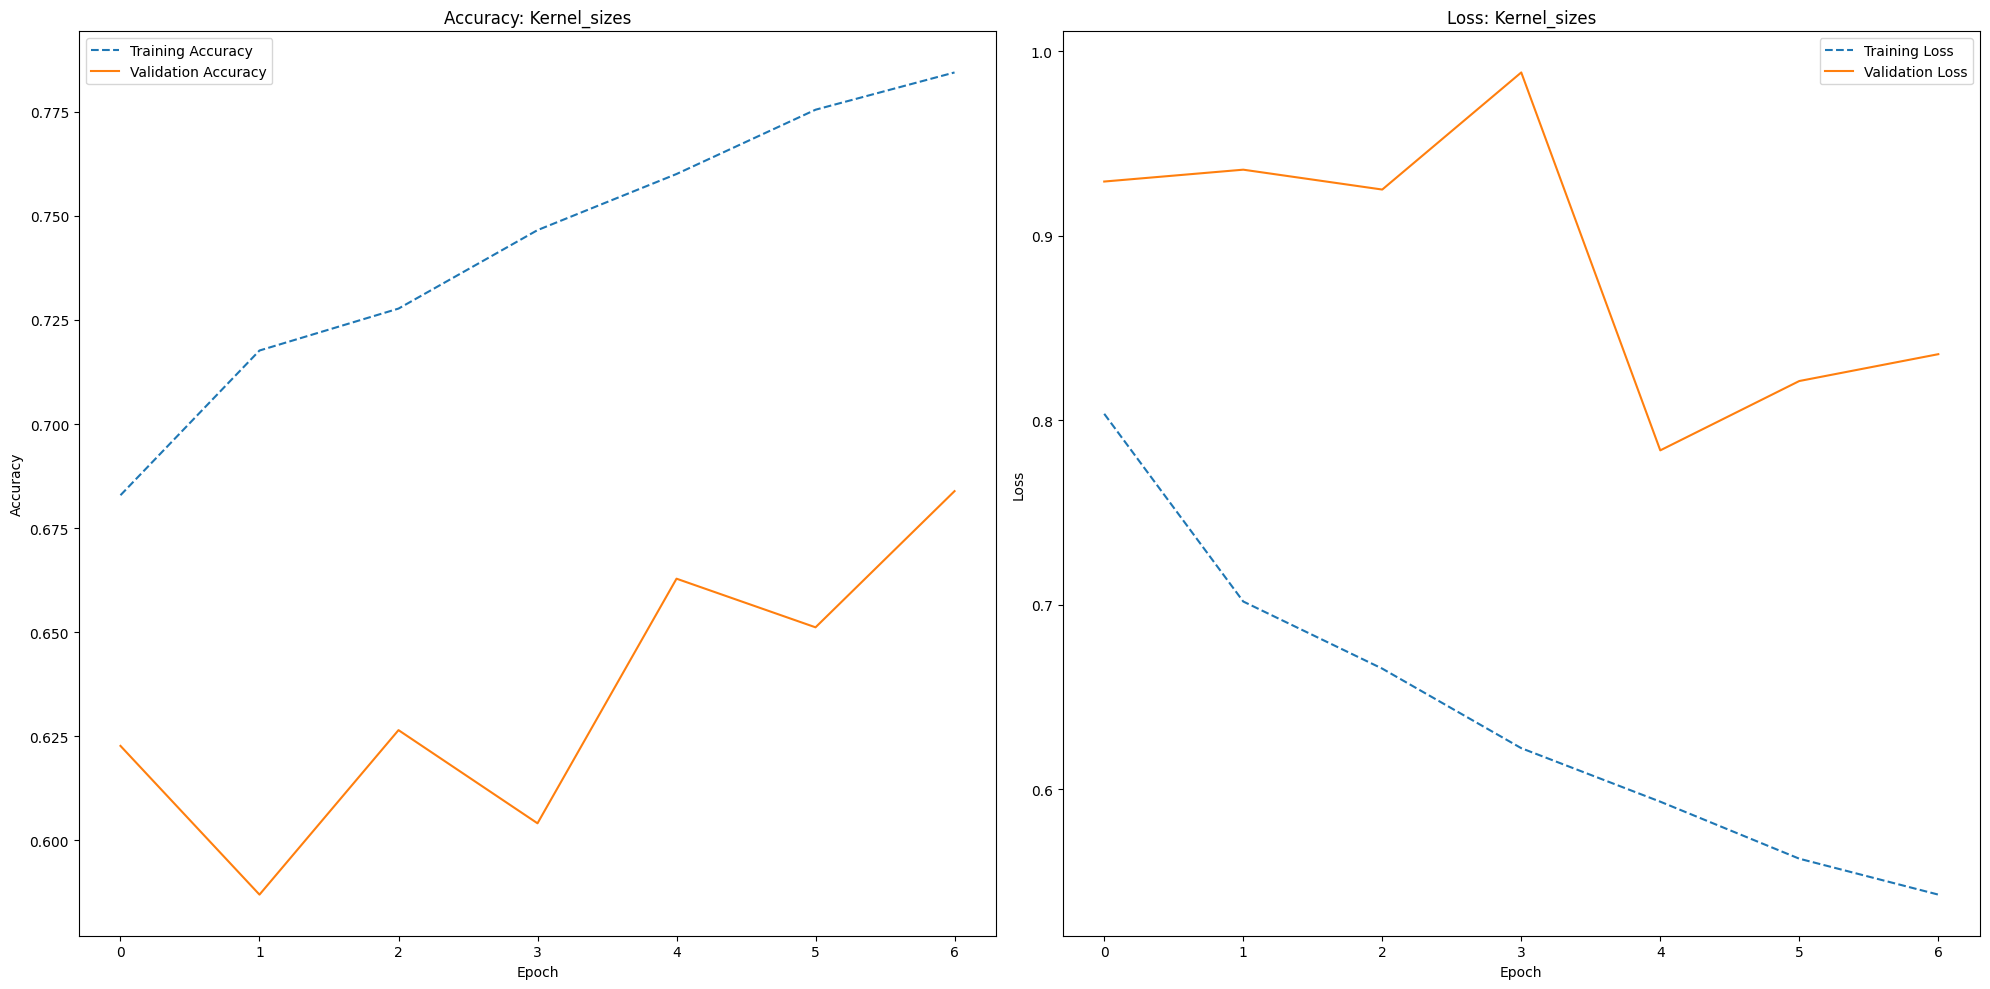

Experiment Kernel_sizes completed.


Starting experiment: Kernel 5,5 и ELU
Parameters: filters=[64, 128, 256, 512, 512], kernel=(5, 5), activation=elu
Epoch 1/7
238/238 ━━━━━━━━━━━━━━━━━━━━ 214s 802ms/step - loss: 1.1745 - sparse_categorical_accuracy: 0.6334 - val_loss: 1.0868 - val_sparse_categorical_accuracy: 0.6787
Epoch 2/7
238/238 ━━━━━━━━━━━━━━━━━━━━ 177s 745ms/step - loss: 0.6339 - sparse_categorical_accuracy: 0.7556 - val_loss: 0.7919 - val_sparse_categorical_accuracy: 0.7343
Epoch 3/7
238/238 ━━━━━━━━━━━━━━━━━━━━ 203s 750ms/step - loss: 0.6064 - sparse_categorical_accuracy: 0.7659 - val_loss: 0.7157 - val_sparse_categorical_accuracy: 0.7244
Epoch 4/7
238/238 ━━━━━━━━━━━━━━━━━━━━ 201s 745ms/step - loss: 0.5741 - sparse_categorical_accuracy: 0.7784 - val_loss: 0.7306 - val_sparse_categorical_accuracy: 0.7412
Epoch 5/7
238/238 ━━━━━━━━━━━━━━━━━━━━ 203s 750ms/step - loss: 0.5470 - sparse_categorical_accuracy: 0.7908 - val_loss: 0.8336 - val_sparse_categorical_accuracy: 0.6487
Epoc

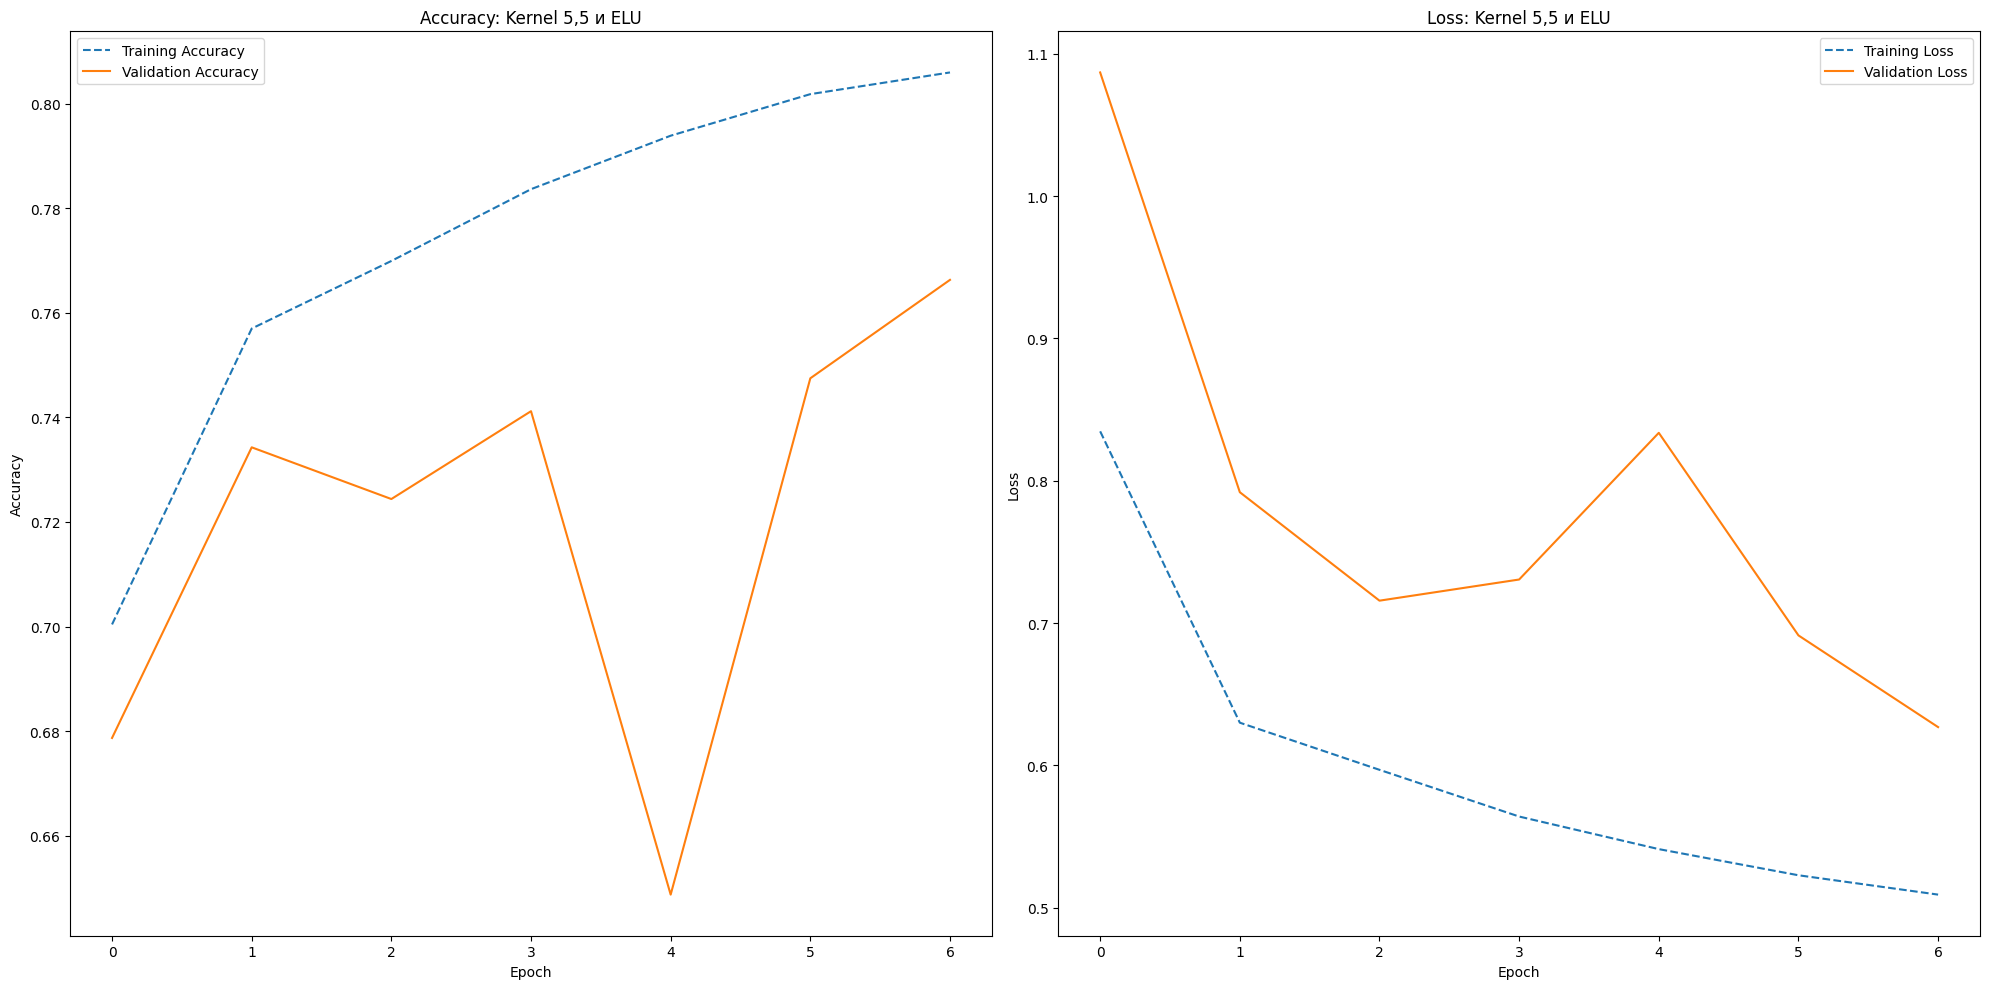

Experiment Kernel 5,5 и ELU completed.


Starting experiment: Filters*2 и SELU
Parameters: filters=[128, 256, 512, 1024, 1024], kernel=(3, 3), activation=selu
Epoch 1/7


ResourceExhaustedError: Graph execution error:

Detected at node StatefulPartitionedCall defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "/usr/local/lib/python3.11/dist-packages/colab_kernel_launcher.py", line 37, in <module>

  File "/usr/local/lib/python3.11/dist-packages/traitlets/config/application.py", line 992, in launch_instance

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelapp.py", line 712, in start

  File "/usr/local/lib/python3.11/dist-packages/tornado/platform/asyncio.py", line 205, in start

  File "/usr/lib/python3.11/asyncio/base_events.py", line 608, in run_forever

  File "/usr/lib/python3.11/asyncio/base_events.py", line 1936, in _run_once

  File "/usr/lib/python3.11/asyncio/events.py", line 84, in _run

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelbase.py", line 510, in dispatch_queue

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelbase.py", line 499, in process_one

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelbase.py", line 406, in dispatch_shell

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelbase.py", line 730, in execute_request

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py", line 383, in do_execute

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/zmqshell.py", line 528, in run_cell

  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 2975, in run_cell

  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3030, in _run_cell

  File "/usr/local/lib/python3.11/dist-packages/IPython/core/async_helpers.py", line 78, in _pseudo_sync_runner

  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3257, in run_cell_async

  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3473, in run_ast_nodes

  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code

  File "<ipython-input-11-600c3075c9f2>", line 15, in <cell line: 0>

  File "/usr/local/lib/python3.11/dist-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/trainer.py", line 371, in fit

  File "/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/trainer.py", line 219, in function

  File "/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/trainer.py", line 132, in multi_step_on_iterator

Out of memory while trying to allocate 5566042736 bytes.
	 [[{{node StatefulPartitionedCall}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_multi_step_on_iterator_483131]

In [11]:
# Цикл обучения
histories = []
for exp in experiments:
    print(f"\nStarting experiment: {exp['name']}")
    print(f"Parameters: filters={exp['filters']}, kernel={exp['kernel_size']}, activation={exp['activation']}")
    # Создание модели
    model = masked_unet(
        class_count=NUM_CLASSES,
        input_shape=(IMG_WIDTH, IMG_HEIGHT, 3),
        filters_list=exp['filters'],
        kernel_size=exp['kernel_size'],
        activation=exp['activation']
    )
    # Обучение
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=7,
        batch_size=8,
        verbose=1
    )
    # Сохранение истории обучения
    histories.append({
        'name': exp['name'],
        'history': history.history,
        'params': exp
    })
    # Визуализация для текущей модели
    plt.figure(figsize=(20, 10))
    # График точности
    plt.subplot(1, 2, 1)
    plt.plot(history.history['sparse_categorical_accuracy'], '--', label='Training Accuracy')
    plt.plot(history.history['val_sparse_categorical_accuracy'], '-', label='Validation Accuracy')
    plt.title(f'Accuracy: {exp["name"]}')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend()
    # График потерь
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], '--', label='Training Loss')
    plt.plot(history.history['val_loss'], '-', label='Validation Loss')
    plt.title(f'Loss: {exp["name"]}')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.tight_layout()
    plt.show()
    # Очистка памяти
    del model
    gc.collect()
    print(f"Experiment {exp['name']} completed.\n")

I0000 00:00:1748177650.120957      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1748177650.121645      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5



Skipping experiment: Basic

Skipping experiment: Kernel 1,1

Skipping experiment: Linear

Skipping experiment: Filters*2

Skipping experiment: Filters_del_2

Skipping experiment: Kernel 5, 5

Skipping experiment: SELU

Skipping experiment: ELU

Skipping experiment: Kernel_sizes

Skipping experiment: Kernel 5,5 и ELU

Starting experiment: Filters*2 и SELU
Parameters: filters=[128, 256, 512, 1024, 1024], kernel=(3, 3), activation=selu
Epoch 1/7


I0000 00:00:1748177671.901481      82 service.cc:148] XLA service 0x7f0d20011180 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1748177671.902055      82 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1748177671.902096      82 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
W0000 00:00:1748177672.778338      82 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert
I0000 00:00:1748177673.482976      82 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1748177779.296570      82 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


237/238 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - loss: 1.9484 - sparse_categorical_accuracy: 0.5027

W0000 00:00:1748178118.395688      80 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert


238/238 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - loss: 1.9457 - sparse_categorical_accuracy: 0.5031

W0000 00:00:1748178191.712101      82 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert
W0000 00:00:1748178199.256004      80 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert


238/238 ━━━━━━━━━━━━━━━━━━━━ 546s 2s/step - loss: 1.9430 - sparse_categorical_accuracy: 0.5035 - val_loss: 1.1892 - val_sparse_categorical_accuracy: 0.6417
Epoch 2/7
238/238 ━━━━━━━━━━━━━━━━━━━━ 346s 1s/step - loss: 0.7666 - sparse_categorical_accuracy: 0.6816 - val_loss: 1.0395 - val_sparse_categorical_accuracy: 0.6675
Epoch 3/7
238/238 ━━━━━━━━━━━━━━━━━━━━ 347s 1s/step - loss: 0.6333 - sparse_categorical_accuracy: 0.7489 - val_loss: 0.8410 - val_sparse_categorical_accuracy: 0.6770
Epoch 4/7
238/238 ━━━━━━━━━━━━━━━━━━━━ 346s 1s/step - loss: 0.6298 - sparse_categorical_accuracy: 0.7519 - val_loss: 0.9188 - val_sparse_categorical_accuracy: 0.6521
Epoch 5/7
238/238 ━━━━━━━━━━━━━━━━━━━━ 346s 1s/step - loss: 0.5748 - sparse_categorical_accuracy: 0.7746 - val_loss: 0.7461 - val_sparse_categorical_accuracy: 0.7016
Epoch 6/7
238/238 ━━━━━━━━━━━━━━━━━━━━ 347s 1s/step - loss: 0.5330 - sparse_categorical_accuracy: 0.7926 - val_loss: 0.9764 - val_sparse_categorical_accuracy: 0.6606
Epoch 7/7
238/

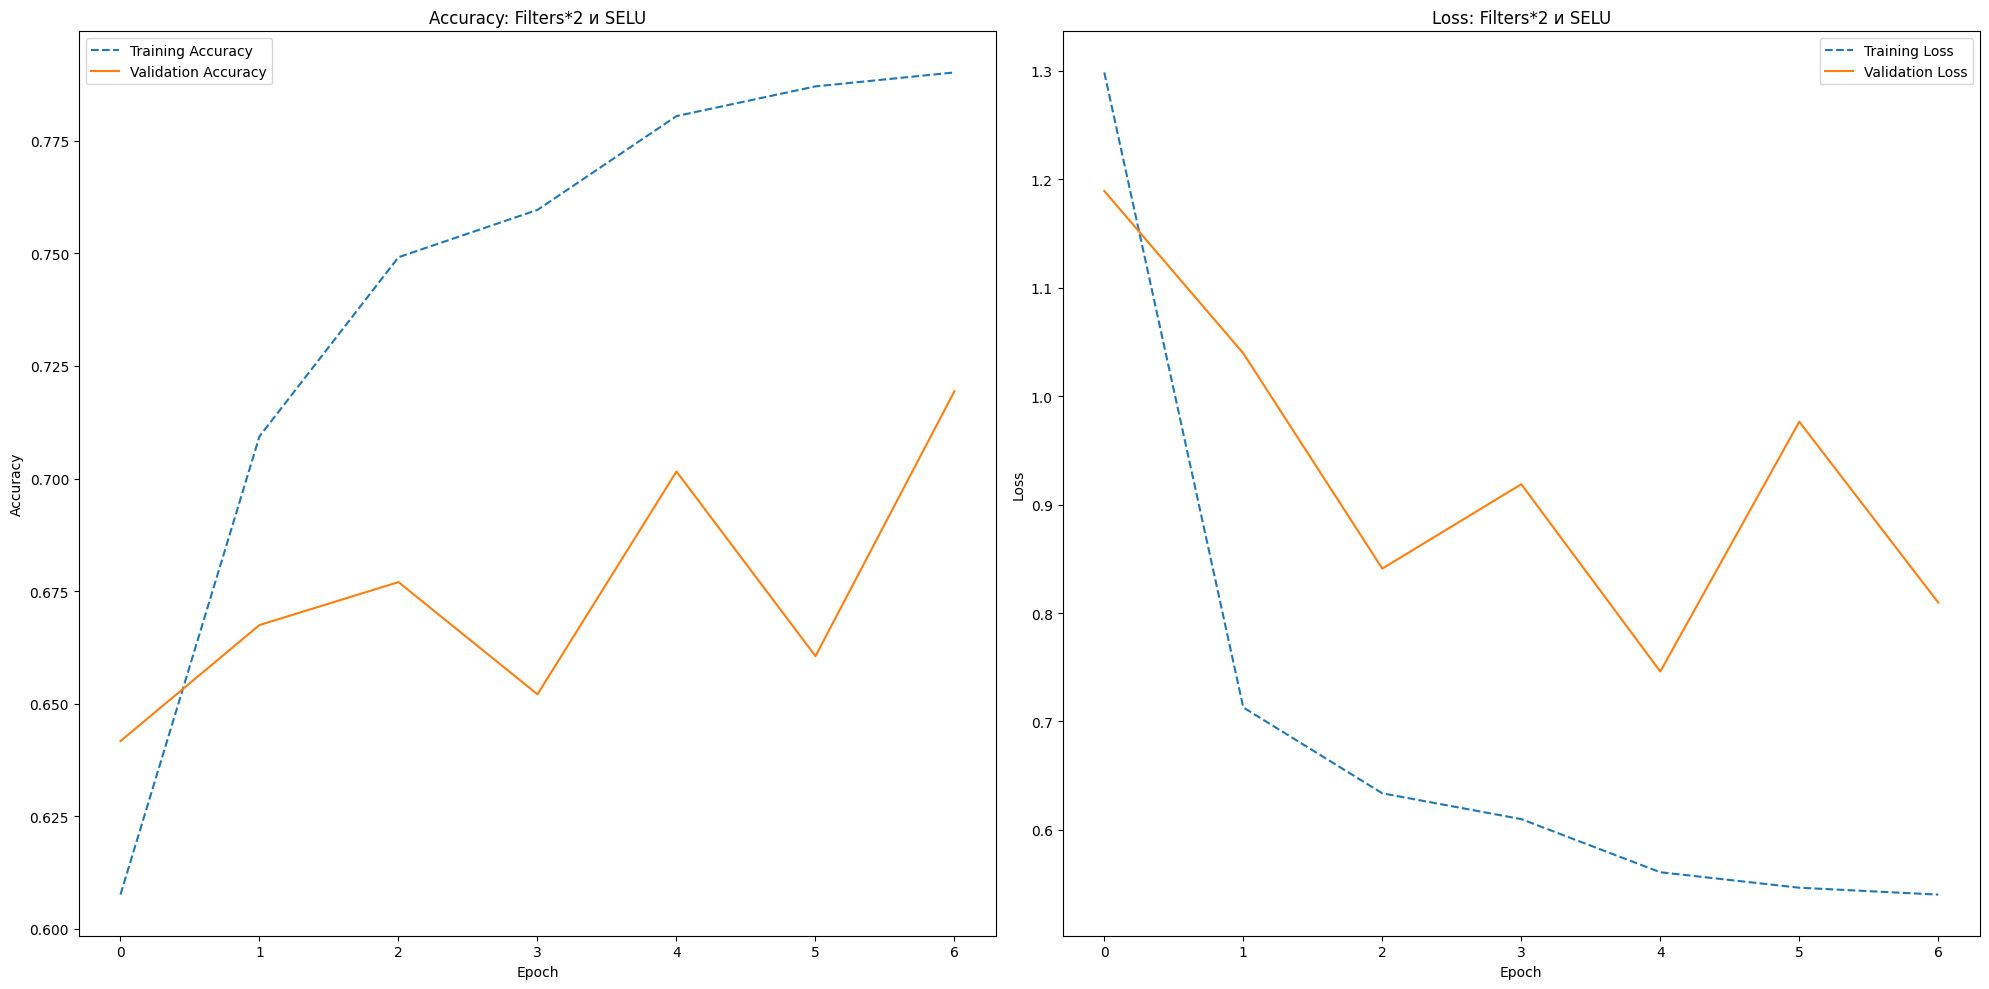

Experiment Filters*2 и SELU completed.



In [8]:
import tensorflow as tf

# Если не все обучились. В списке - модели для пропуска
skip_list = ["Basic", "Kernel 1,1", "Linear", "Filters*2", "Filters_del_2", "Kernel 5, 5", "SELU", "ELU", "Kernel_sizes", "Kernel 5,5 и ELU"]
with tf.device('/GPU:0'):
    # Цикл обучения
    histories = []
    for exp in experiments:
        if exp['name'] in skip_list:
            print(f"\nSkipping experiment: {exp['name']}")
            continue
        print(f"\nStarting experiment: {exp['name']}")
        print(f"Parameters: filters={exp['filters']}, kernel={exp['kernel_size']}, activation={exp['activation']}")
        # Создание модели
        model = masked_unet(
            class_count=NUM_CLASSES,
            input_shape=(IMG_WIDTH, IMG_HEIGHT, 3),
            filters_list=exp['filters'],
            kernel_size=exp['kernel_size'],
            activation=exp['activation']
        )
        # Обучение
        history = model.fit(
            X_train, y_train,
            validation_data=(X_val, y_val),
            epochs=7,
            batch_size=8,
            verbose=1
        )
        # Сохранение истории обучения
        histories.append({
            'name': exp['name'],
            'history': history.history,
            'params': exp
        })
        # Сохранение весов модели
        safe_name = exp['name'].replace(' ', '_').lower()
        weights_filename = f"{safe_name}.weights.h5"
        model.save_weights(weights_filename)
        print(f"Веса в {weights_filename}")
        # Визуализация для текущей модели
        plt.figure(figsize=(20, 10))
        # График точности
        plt.subplot(1, 2, 1)
        plt.plot(history.history['sparse_categorical_accuracy'], '--', label='Training Accuracy')
        plt.plot(history.history['val_sparse_categorical_accuracy'], '-', label='Validation Accuracy')
        plt.title(f'Accuracy: {exp["name"]}')
        plt.ylabel('Accuracy')
        plt.xlabel('Epoch')
        plt.legend()
        # График потерь
        plt.subplot(1, 2, 2)
        plt.plot(history.history['loss'], '--', label='Training Loss')
        plt.plot(history.history['val_loss'], '-', label='Validation Loss')
        plt.title(f'Loss: {exp["name"]}')
        plt.ylabel('Loss')
        plt.xlabel('Epoch')
        plt.legend()
        plt.tight_layout()
        plt.show()
        # Очистка памяти
        del model
        gc.collect()
        print(f"Experiment {exp['name']} completed.\n")